In [1]:
%matplotlib inline
%load_ext dotenv
%dotenv env.sh
import pandas as pd
import numpy as np
import plotnine as pn
import os
import os.path as osp
from cytokit import config as ck_config
from cytokit.function import data as ck_data
exp_variant = 'v02'

In [4]:
df = pd.read_csv('experiments.csv')
df['rep'] = df['grid'].str.extract('XY(\d+)', expand=False).astype(int)
df['has_peptide'] = df['cond'].str.match(r'.*\-wp(\-|$)').map({True: 'w/ Peptide', False: 'No Peptide'})
df['cell_count'] = df['name'].str.extract(r'([\d.]+kT)', expand=False).fillna('0kT')
df['sta_conc'] = df['name'].str.extract(r'sta-([\d.]+)-20um', expand=False)
df['label'] = df.apply(lambda r: '{}-{}-r{:01d}'.format(r['cell_count'], r['sta_conc'], r['rep']), axis=1)
df['key'] = df.apply(lambda r: '{}-{}-{}'.format(r['has_peptide'], r['sta_conc'], r['cell_count']), axis=1)
df['rep'] = df['rep'].apply(lambda v: 'r{}'.format(v))
df['output_dir'] = df.apply(lambda r: osp.join(os.environ['EXP_GROUP_OUT_DIR'], r['name'], exp_variant), axis=1)

# Filter to experiments with data and load config
df = df[df.apply(lambda r: osp.exists(osp.join(r['output_dir'], 'cytometry', 'data.csv')), axis=1)]
df['config'] = df.apply(lambda r: ck_config.load(osp.join(r['output_dir'], 'config')), axis=1)
df.head()

,name,conf,dir,grid,n_ch,n_tiles,n_z,cond,z_pitch,rep,has_peptide,cell_count,sta_conc,label,key,output_dir,config
0,sta-00.125-20um-s-XY01,experiment.yaml,0125uMsta-20um-grids,XY01,3,27,8,sta-00.125-20um-s,200,r1,No Peptide,0kT,00.125,0kT-00.125-r1,No Peptide-00.125-0kT,/lab/data/spheroid/20190703-sta-titration/outp...,"{'name': 'sta-00.125-20um-s-XY01', 'processor'..."
1,sta-00.125-20um-s-XY02,experiment.yaml,0125uMsta-20um-grids,XY02,3,27,7,sta-00.125-20um-s,200,r2,No Peptide,0kT,00.125,0kT-00.125-r2,No Peptide-00.125-0kT,/lab/data/spheroid/20190703-sta-titration/outp...,"{'name': 'sta-00.125-20um-s-XY02', 'processor'..."
2,sta-00.125-20um-s-XY03,experiment.yaml,0125uMsta-20um-grids,XY03,3,27,9,sta-00.125-20um-s,200,r3,No Peptide,0kT,00.125,0kT-00.125-r3,No Peptide-00.125-0kT,/lab/data/spheroid/20190703-sta-titration/outp...,"{'name': 'sta-00.125-20um-s-XY03', 'processor'..."
3,sta-00.250-20um-s-XY01,experiment.yaml,025uMsta-20um-grids,XY01,3,27,8,sta-00.250-20um-s,200,r1,No Peptide,0kT,00.250,0kT-00.250-r1,No Peptide-00.250-0kT,/lab/data/spheroid/20190703-sta-titration/outp...,"{'name': 'sta-00.250-20um-s-XY01', 'processor'..."
4,sta-00.250-20um-s-XY02,experiment.yaml,025uMsta-20um-grids,XY02,3,27,7,sta-00.250-20um-s,200,r2,No Peptide,0kT,00.250,0kT-00.250-r2,No Peptide-00.250-0kT,/lab/data/spheroid/20190703-sta-titration/outp...,"{'name': 'sta-00.250-20um-s-XY02', 'processor'..."


### Cell Data 

In [5]:
dfa = pd.concat([
    ck_data.get_cytometry_data(r['output_dir'], r['config']).assign(**r[[
        'name', 'grid', 'cond', 'has_peptide', 'cell_count', 'sta_conc', 'label', 'rep', 'key'
    ]].add_prefix('exp:').to_dict())
    for i, r in df.iterrows()
])
dfa = dfa.rename(columns=lambda c: c.replace(':', '_'))
dfa.head()

,cb_on_border,ci_BF_mean,ci_HOECHST_mean,ci_SPHEROID_mean,ci_SYTOX_mean,cm_circularity,cm_diameter,cm_diameter_vx,cm_perimeter,cm_size,...,region_index,rid,rx,ry,tile_index,tile_x,tile_y,x,y,z
0,1,55006.515222,10452.180328,0.0,5951.402810,0.755344,8.800741,23.316803,84.284271,60.831472,...,0,0,712.0,1000.423888,0,0,0,712.0,1000.423888,0
1,1,44000.091335,12537.135831,0.0,5287.817330,0.755344,8.800741,23.316803,84.284271,60.831472,...,0,1,663.0,1000.423888,0,0,0,663.0,1000.423888,0
2,1,39633.070258,15039.430913,0.0,4564.243560,0.755344,8.800741,23.316803,84.284271,60.831472,...,0,2,499.0,1000.423888,0,0,0,499.0,1000.423888,0
3,1,47130.291057,6130.796748,0.0,3006.747967,0.875737,10.561919,27.982893,93.941125,87.614415,...,0,3,780.0,997.482927,0,0,0,780.0,997.482927,0
4,0,45443.662607,16166.493301,0.0,7049.468940,0.943520,12.203288,32.331558,104.568542,116.961682,...,0,4,622.0,986.000000,0,0,0,622.0,986.000000,0


In [6]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409567 entries, 0 to 39
Data columns (total 44 columns):
cb_on_border        409567 non-null object
ci_BF_mean          409567 non-null float64
ci_HOECHST_mean     409567 non-null float64
ci_SPHEROID_mean    409567 non-null float64
ci_SYTOX_mean       409567 non-null float64
cm_circularity      409567 non-null float64
cm_diameter         409567 non-null float64
cm_diameter_vx      409567 non-null float64
cm_perimeter        409567 non-null float64
cm_size             409567 non-null float64
cm_size_vx          409567 non-null object
cm_solidity         409567 non-null float64
exp_cell_count      409567 non-null object
exp_cond            409567 non-null object
exp_grid            409567 non-null object
exp_has_peptide     409567 non-null object
exp_key             409567 non-null object
exp_label           409567 non-null object
exp_name            409567 non-null object
exp_rep             409567 non-null object
exp_sta_conc        409

In [7]:
dfa['cb_on_border'].value_counts()

0    361106
1     48461
Name: cb_on_border, dtype: int64

In [8]:
def select_z_plane(g):
    z = g['z'].value_counts().idxmax()
    return g[g['z'] == z]

dfs = (
    dfa
    # Restrict to cells in a spheroid
    .pipe(lambda df: df[df['ci_SPHEROID_mean'] > 0])
    # Select z plane with most cells
    .groupby(['exp_name', 'tile_index'], group_keys=False).apply(select_z_plane)
)
assert (dfs.groupby(['exp_name', 'tile_index'])['z'].nunique() == 1).all()
dfs.groupby(['exp_name', 'tile_index'])['z'].max().unstack().fillna(0).astype(int)

tile_index,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
exp_name,,,,,,,,,,,,,,,,,,,,,
sta-00.000-20um-s-XY01,7,7,7,7,7,7,0,7,8,5,...,7,7,7,7,7,6,7,6,7,7
sta-00.000-20um-s-XY02,0,8,7,8,8,7,7,7,8,7,...,8,8,7,7,8,7,7,7,7,7
sta-00.000-20um-s-XY03,4,5,5,5,5,0,0,5,5,6,...,0,6,6,6,6,5,5,0,6,6
sta-00.125-20um-s-XY01,6,5,5,5,5,5,5,5,5,5,...,5,4,5,5,5,5,5,5,5,5
sta-00.125-20um-s-XY02,5,5,5,5,5,5,5,5,5,5,...,4,0,5,4,3,4,0,0,4,4
sta-00.125-20um-s-XY03,6,6,6,6,7,6,6,6,6,6,...,0,5,6,6,6,6,0,6,6,6
sta-00.250-20um-s-XY01,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
sta-00.250-20um-s-XY02,0,5,5,5,5,5,5,5,5,5,...,5,4,5,5,5,5,4,5,4,5
sta-00.250-20um-s-XY03,6,5,6,6,6,6,6,6,6,6,...,0,6,6,6,6,6,6,6,5,6


In [9]:
dfsct = dfs.groupby(['exp_name', 'exp_key', 'exp_has_peptide', 'exp_rep', 'exp_sta_conc']).size().rename('value').reset_index()
dfsct

,exp_name,exp_key,exp_has_peptide,exp_rep,exp_sta_conc,value
0,sta-00.000-20um-s-XY01,No Peptide-00.000-0kT,No Peptide,r1,00.000,1368
1,sta-00.000-20um-s-XY02,No Peptide-00.000-0kT,No Peptide,r2,00.000,1640
2,sta-00.000-20um-s-XY03,No Peptide-00.000-0kT,No Peptide,r3,00.000,1275
3,sta-00.125-20um-s-XY01,No Peptide-00.125-0kT,No Peptide,r1,00.125,1878
4,sta-00.125-20um-s-XY02,No Peptide-00.125-0kT,No Peptide,r2,00.125,1376
5,sta-00.125-20um-s-XY03,No Peptide-00.125-0kT,No Peptide,r3,00.125,2248
6,sta-00.250-20um-s-XY01,No Peptide-00.250-0kT,No Peptide,r1,00.250,1956
7,sta-00.250-20um-s-XY02,No Peptide-00.250-0kT,No Peptide,r2,00.250,2077
8,sta-00.250-20um-s-XY03,No Peptide-00.250-0kT,No Peptide,r3,00.250,1963
9,sta-00.500-20um-s-XY01,No Peptide-00.500-0kT,No Peptide,r1,00.500,1528


In [10]:
def plot_series(df, width=.1):
    dfg = df.groupby(['exp_key', 'exp_has_peptide', 'exp_sta_conc'])['value'].mean().rename('value').reset_index()
    return (
        pn.ggplot(df, pn.aes(x='exp_key', y='value')) + 
        pn.geom_jitter(
            width=width, height=0, random_state=0, 
            mapping=pn.aes(fill='exp_rep', color='exp_rep', shape='exp_has_peptide', size='exp_sta_conc')
        ) + 
        pn.geom_point(data=dfg, mapping=pn.aes(x='exp_key', y='value', shape='exp_has_peptide', size='exp_sta_conc'), color='black', fill='black') +
        pn.geom_line(data=dfg, mapping=pn.aes(x='exp_key', y='value', group=1)) +
        pn.theme_bw() + 
        pn.labs(x='Condition', color='Replicate', fill='Replicate', shape='Peptide', size='STA') + 
        pn.scale_size_discrete(range=(3, 5)) + 
        pn.theme(figure_size=(12, 4), axis_text_x=pn.element_text(rotation=45, hjust=1))
    )

In [11]:
dfsct[dfsct['exp_key'] == 'No Peptide-0uM-2000kT']

,exp_name,exp_key,exp_has_peptide,exp_rep,exp_sta_conc,value


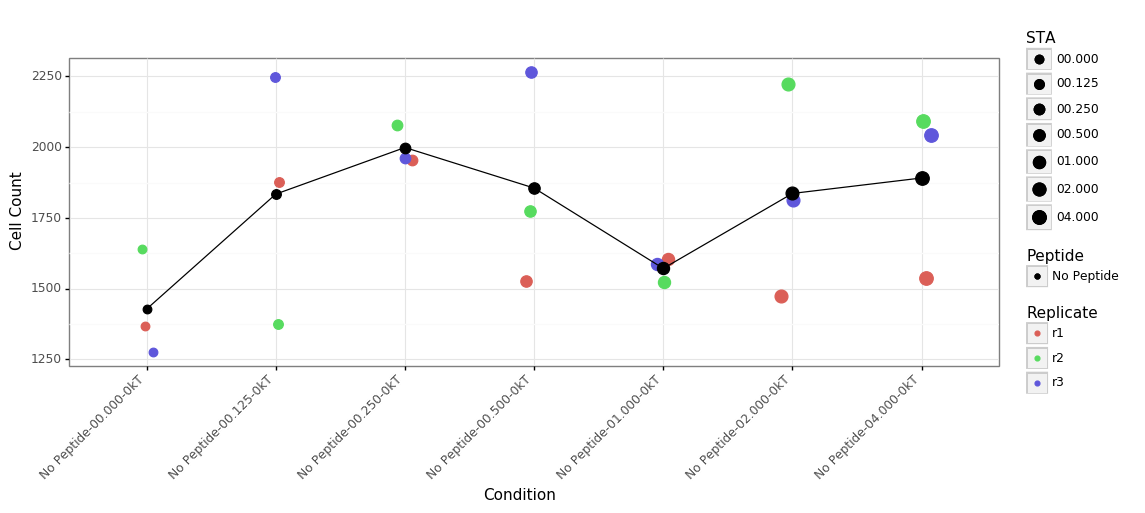

<ggplot: (-9223363280999769284)>

In [12]:
plot_series(dfsct) + pn.labs(y='Cell Count')

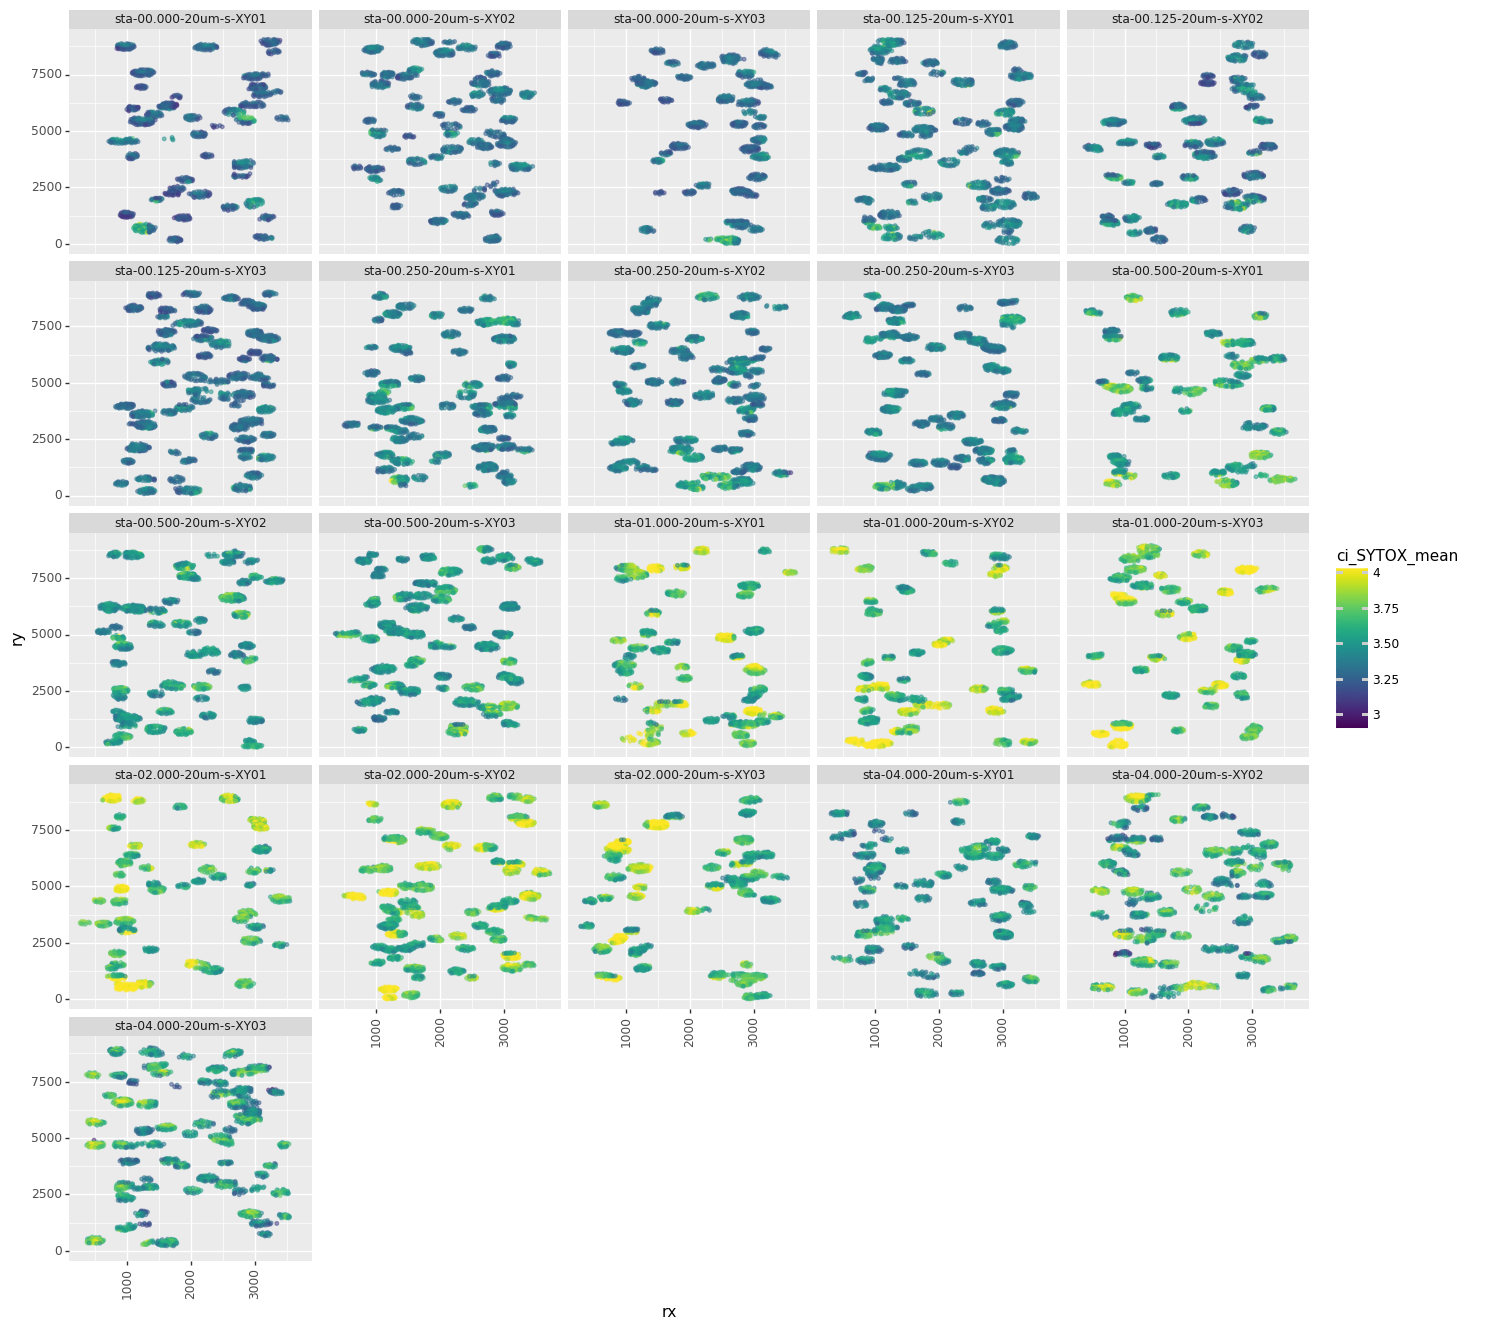

<ggplot: (-9223363280997125814)>

In [13]:
(
    pn.ggplot(
        dfs.assign(ci_SYTOX_mean=lambda df: df['ci_SYTOX_mean'].apply(np.log10).clip(0, 4)), 
        pn.aes(x='rx', y='ry', fill='ci_SYTOX_mean', color='ci_SYTOX_mean')
    ) + 
    pn.geom_point(size=1, alpha=.5) + 
    pn.facet_wrap('~exp_name') + 
    pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(16, 16))
)

In [14]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37243 entries, 493 to 438
Data columns (total 44 columns):
cb_on_border        37243 non-null object
ci_BF_mean          37243 non-null float64
ci_HOECHST_mean     37243 non-null float64
ci_SPHEROID_mean    37243 non-null float64
ci_SYTOX_mean       37243 non-null float64
cm_circularity      37243 non-null float64
cm_diameter         37243 non-null float64
cm_diameter_vx      37243 non-null float64
cm_perimeter        37243 non-null float64
cm_size             37243 non-null float64
cm_size_vx          37243 non-null object
cm_solidity         37243 non-null float64
exp_cell_count      37243 non-null object
exp_cond            37243 non-null object
exp_grid            37243 non-null object
exp_has_peptide     37243 non-null object
exp_key             37243 non-null object
exp_label           37243 non-null object
exp_name            37243 non-null object
exp_rep             37243 non-null object
exp_sta_conc        37243 non-null object

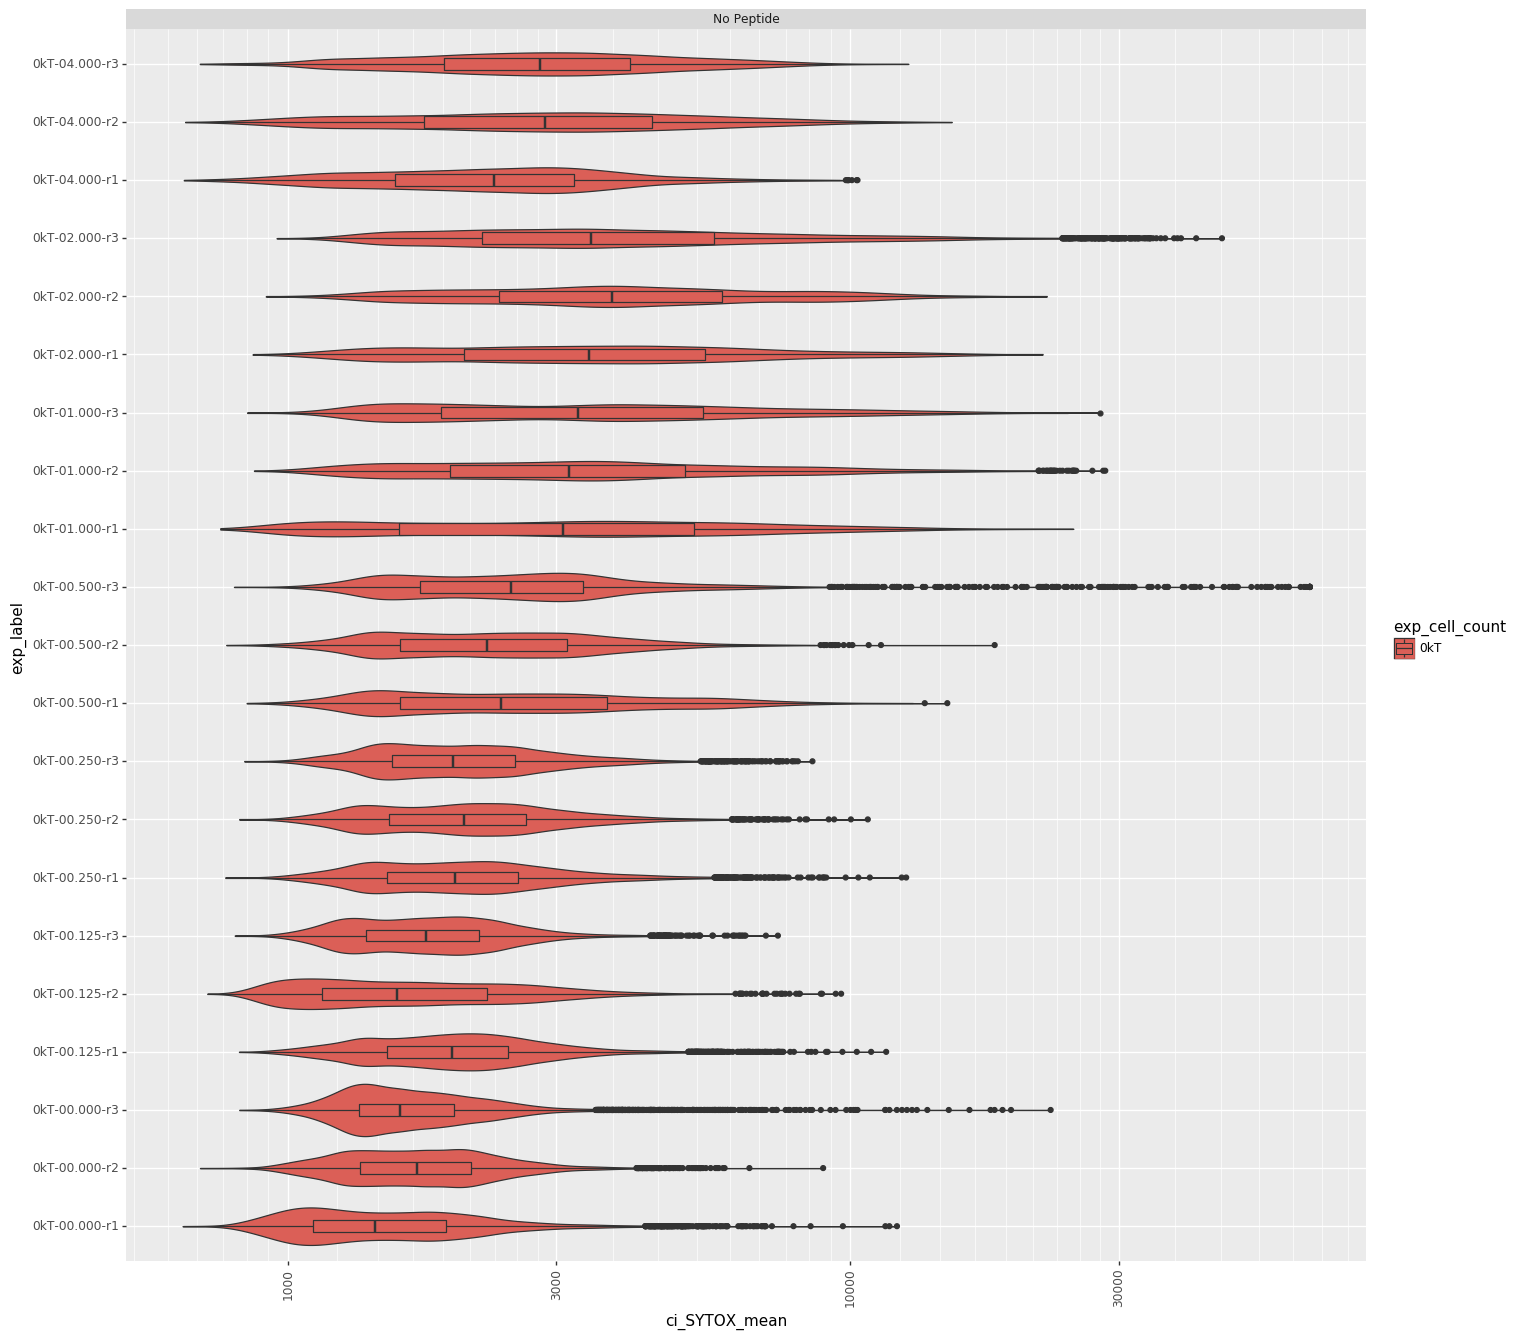

<ggplot: (8755849782760)>

In [15]:
(
    pn.ggplot(
        dfa,
        pn.aes(x='exp_label', y='ci_SYTOX_mean', fill='exp_cell_count')
    ) + 
    pn.geom_violin() + 
    pn.geom_boxplot(width=.2) + 
    pn.coord_flip() + 
    pn.scale_y_log10() +
    pn.facet_wrap('~ exp_has_peptide', ncol=1, nrow=2, scales='free') + 
    pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(16, 16))
)

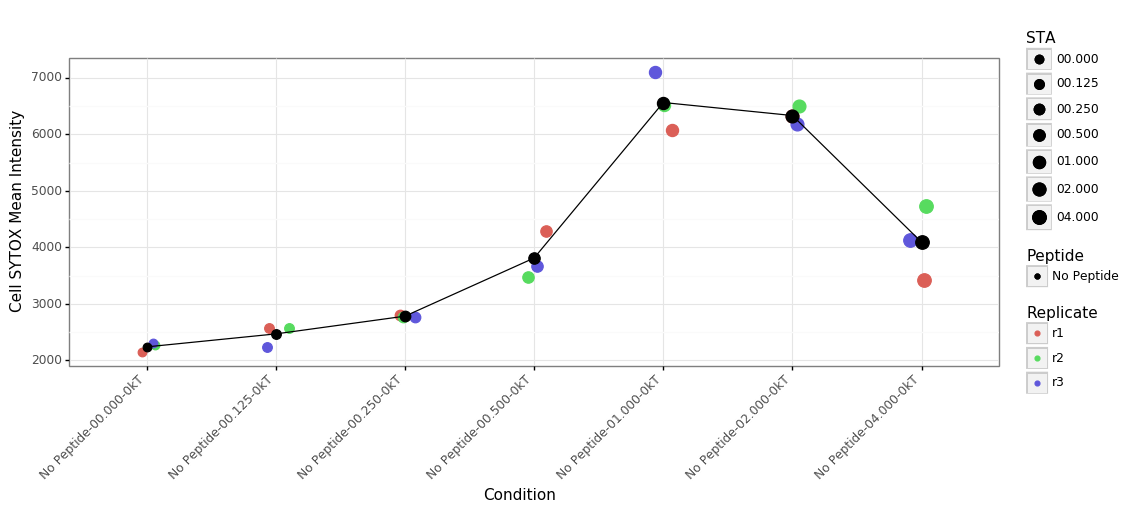

<ggplot: (8755844999600)>

In [16]:
dfsval = dfs.groupby(['exp_name', 'exp_key', 'exp_has_peptide', 'exp_rep', 'exp_sta_conc'])['ci_SYTOX_mean'].mean().rename('value').reset_index()
plot_series(dfsval) + pn.labs(y='Cell SYTOX Mean Intensity')

### Spheroid Data

In [17]:
dfsh = pd.concat([
    pd.read_csv(osp.join(r['output_dir'], 'cytometry', 'data.spheroid.csv')).assign(**r[[
        'name', 'grid', 'cond', 'has_peptide', 'cell_count', 'sta_conc', 'label', 'rep', 'key'
    ]].add_prefix('exp:').to_dict())
    for i, r in df.iterrows()
])
dfsh = dfsh.rename(columns=lambda c: c.replace(':', '_'))
dfsh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1389 entries, 0 to 69
Data columns (total 28 columns):
cb_on_border       1389 non-null int64
ci_BF_mean         1389 non-null float64
ci_HOECHST_mean    1389 non-null float64
ci_SYTOX_mean      1389 non-null float64
cm_circularity     1389 non-null float64
cm_diameter        1389 non-null float64
cm_perimeter       1389 non-null float64
cm_size            1389 non-null int64
cm_solidity        1389 non-null float64
exp_cell_count     1389 non-null object
exp_cond           1389 non-null object
exp_grid           1389 non-null object
exp_has_peptide    1389 non-null object
exp_key            1389 non-null object
exp_label          1389 non-null object
exp_name           1389 non-null object
exp_rep            1389 non-null object
exp_sta_conc       1389 non-null object
id                 1389 non-null int64
nb_on_border       1389 non-null int64
nm_circularity     1389 non-null float64
nm_diameter        1389 non-null float64
nm_perimet

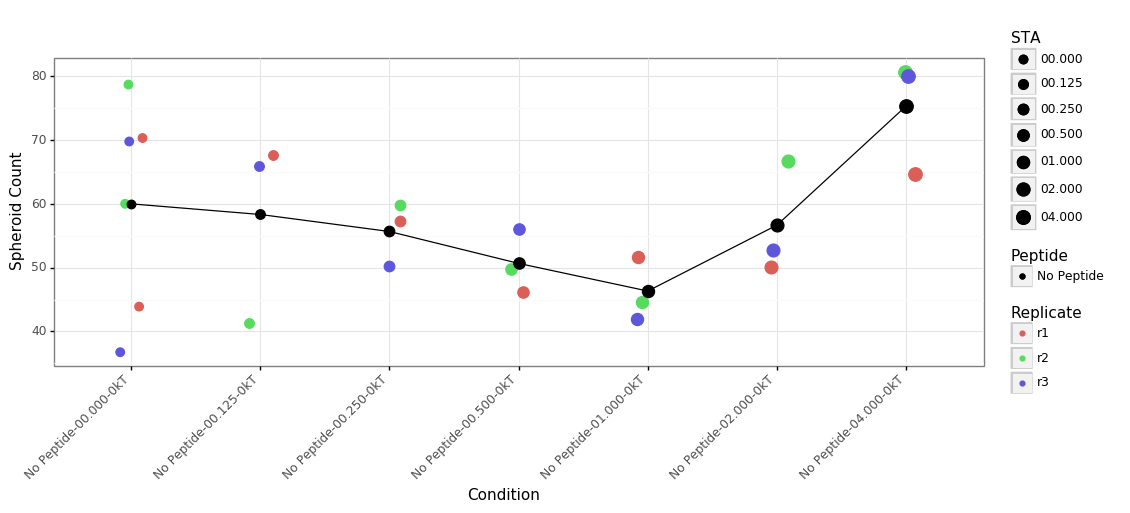

<ggplot: (-9223363281009806364)>

In [18]:
dfshct = dfsh.groupby(['exp_name', 'exp_key', 'exp_has_peptide', 'exp_rep', 'exp_sta_conc']).size().rename('value').reset_index()
plot_series(dfshct) + pn.labs(y='Spheroid Count')

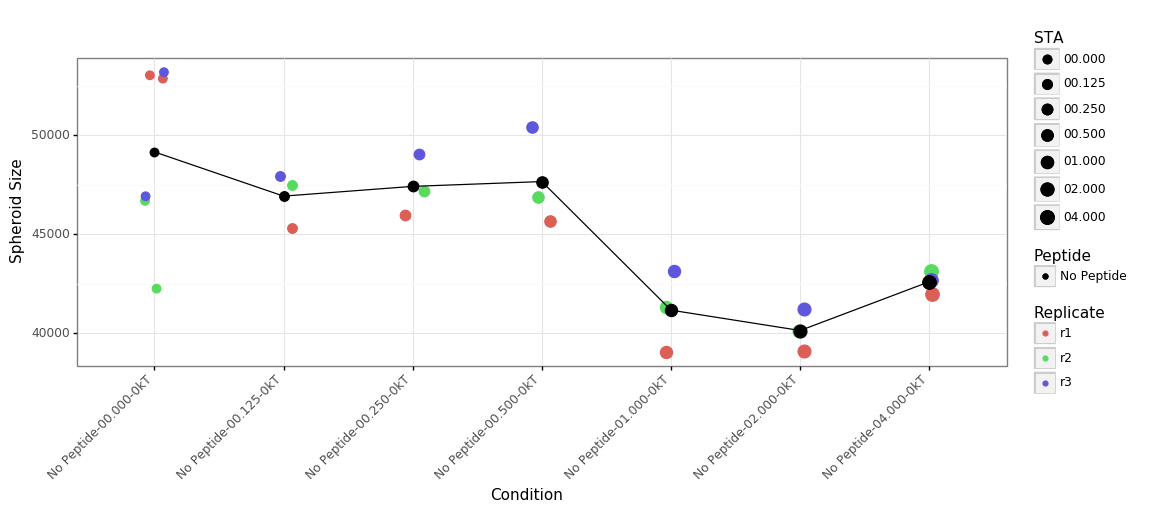

<ggplot: (-9223363281007359407)>

In [19]:
dfshsz = dfsh.groupby(['exp_name', 'exp_key', 'exp_has_peptide', 'exp_rep', 'exp_sta_conc'])['cm_size'].mean().rename('value').reset_index()
plot_series(dfshsz) + pn.labs(y='Spheroid Size')

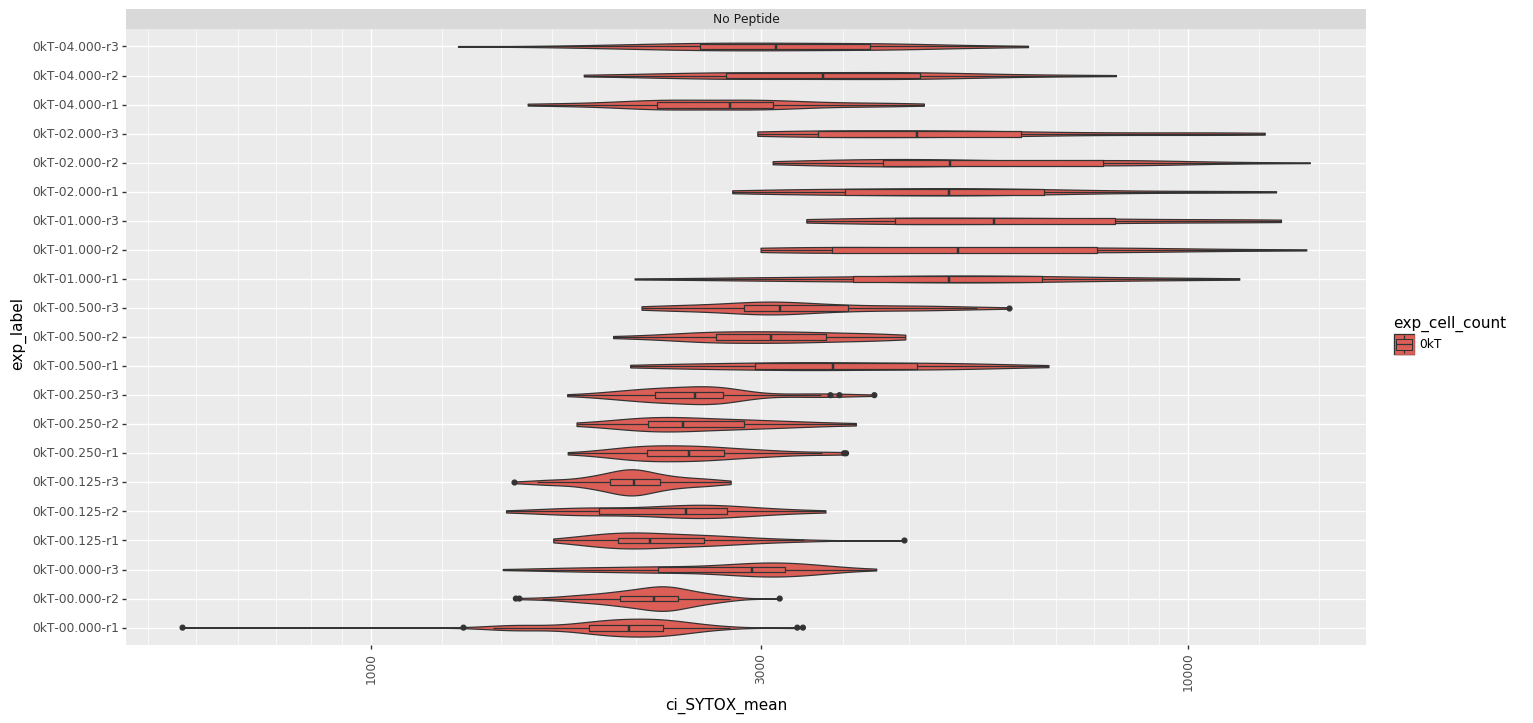

<ggplot: (8755841682822)>

In [20]:
(
    pn.ggplot(
        dfsh,
        pn.aes(x='exp_label', y='ci_SYTOX_mean', fill='exp_cell_count')
    ) + 
    pn.geom_violin() + 
    pn.geom_boxplot(width=.2) + 
    pn.coord_flip() + 
    pn.scale_y_log10() +
    pn.facet_wrap('~ exp_has_peptide', ncol=2, nrow=1, scales='free') + 
    pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(16, 8))
)

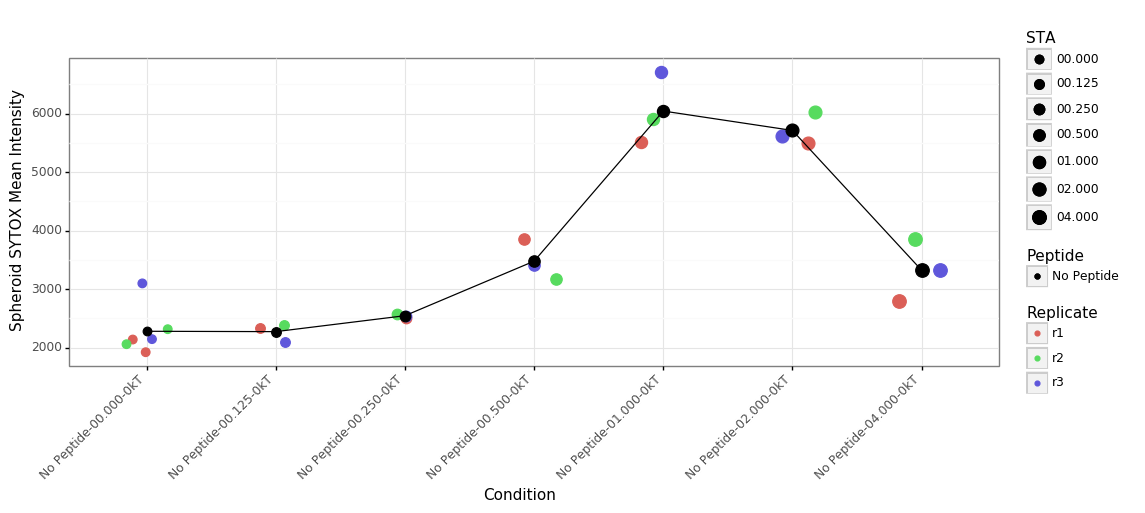

<ggplot: (8755845017913)>

In [21]:
dfshval = dfsh.groupby(['exp_name', 'exp_key', 'exp_has_peptide', 'exp_rep', 'exp_sta_conc'])['ci_SYTOX_mean'].mean().rename('value').reset_index()
plot_series(dfshval, width=.2) + pn.labs(y='Spheroid SYTOX Mean Intensity')

In [34]:
dfsh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1983 entries, 0 to 72
Data columns (total 28 columns):
id                 1983 non-null int64
x                  1983 non-null float64
y                  1983 non-null float64
z                  1983 non-null int64
cm_circularity     1983 non-null float64
cm_diameter        1983 non-null float64
cm_perimeter       1983 non-null float64
cm_size            1983 non-null int64
cm_solidity        1983 non-null float64
nm_circularity     1983 non-null float64
nm_diameter        1983 non-null float64
nm_perimeter       1983 non-null float64
nm_size            1983 non-null int64
nm_solidity        1983 non-null float64
cb_on_border       1983 non-null int64
nb_on_border       1983 non-null int64
ci_SYTOX_mean      1983 non-null float64
ci_HOECHST_mean    1983 non-null float64
ci_BF_mean         1983 non-null float64
exp_cell_count     1983 non-null object
exp_cond           1983 non-null object
exp_grid           1983 non-null object
exp_has_

### Horizontal Staining Bias

In [35]:
dfsh['exp_name'].unique()

array(['0000kT-0uM-np-XY01-1', '0000kT-0uM-np-XY02-2',
       '0000kT-0uM-np-XY03-3', '0000kT-4uM-np-XY01-1',
       '0000kT-4uM-np-XY02-2', '0000kT-4uM-np-XY03-3',
       '0500kT-0uM-np-XY01-1', '0500kT-0uM-np-XY02-2',
       '0500kT-0uM-np-XY03-3', '0500kT-0uM-wp-XY01-1',
       '0500kT-0uM-wp-XY02-2', '0500kT-0uM-wp-XY03-3',
       '1000kT-0uM-np-XY01-1', '1000kT-0uM-np-XY02-2',
       '1000kT-0uM-np-XY03-3', '1000kT-0uM-wp-XY01-1',
       '1000kT-0uM-wp-XY02-2', '1000kT-0uM-wp-XY03-3',
       '2000kT-0uM-np-XY01-1', '2000kT-0uM-np-XY02-2',
       '2000kT-0uM-np-XY03-3', '2000kT-0uM-wp-XY01-1',
       '2000kT-0uM-wp-XY02-2', '2000kT-0uM-wp-XY03-3',
       '4000kT-0uM-np-XY01-1', '4000kT-0uM-np-XY02-2',
       '4000kT-0uM-np-XY03-3', '4000kT-0uM-wp-XY01-1',
       '4000kT-0uM-wp-XY02-2', '4000kT-0uM-wp-XY03-3'], dtype=object)

In [36]:
bad_exps = []

In [37]:
(
    dfsh
    .pipe(lambda df: df[~df['exp_name'].isin(bad_exps)])
    .assign(pos=lambda df: pd.cut(df['x'], bins=10))
    .groupby(['exp_name','exp_has_peptide', 'exp_sta_conc', 'pos'])['ci_SYTOX_mean'].mean().rename('value').reset_index()
    .groupby(['exp_name','exp_has_peptide', 'exp_sta_conc'])
    .apply(lambda g: g.set_index('pos')['value'].rolling(window=3, min_periods=1, center=True).mean())
    .rename('value').reset_index()
).head()

,exp_name,exp_has_peptide,exp_sta_conc,pos,value
0,0000kT-0uM-np-XY01-1,No Peptide,0uM,"(330.629, 669.554]",2336.312604
1,0000kT-0uM-np-XY01-1,No Peptide,0uM,"(669.554, 1005.123]",2375.309017
2,0000kT-0uM-np-XY01-1,No Peptide,0uM,"(1005.123, 1340.692]",2235.498039
3,0000kT-0uM-np-XY01-1,No Peptide,0uM,"(1340.692, 1676.261]",2271.804068
4,0000kT-0uM-np-XY01-1,No Peptide,0uM,"(1676.261, 2011.83]",2437.352150


In [38]:
dfsh['x'].describe()

count    1983.000000
mean     1995.246654
std       833.308479
min       333.984490
25%      1190.928319
50%      1976.287652
75%      2794.012986
max      3689.675631
Name: x, dtype: float64

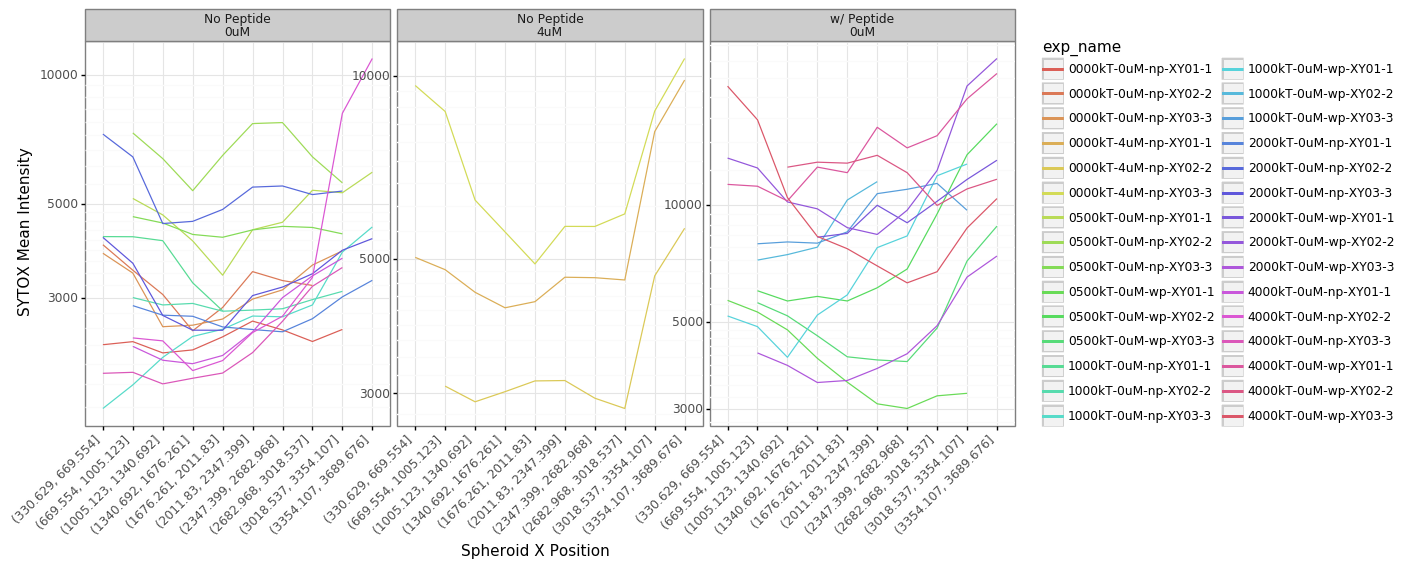

<ggplot: (-9223363273524650713)>

In [39]:
dfp = (
    dfsh
    .pipe(lambda df: df[~df['exp_name'].isin(bad_exps)])
    .assign(pos=lambda df: pd.cut(df['x'], bins=10))
    .groupby(['exp_name','exp_has_peptide', 'exp_sta_conc', 'pos'])['ci_SYTOX_mean'].mean().rename('value').reset_index()
    .groupby(['exp_name','exp_has_peptide', 'exp_sta_conc'])
    .apply(lambda g: g.set_index('pos')['value'].rolling(window=3, min_periods=1, center=True).mean())
    .rename('value').reset_index()
)
(
    pn.ggplot(
        dfp,
        pn.aes(x='pos', y='value', color='exp_name', group='exp_name')
    ) + 
    pn.geom_line() +
    pn.facet_wrap('~ exp_has_peptide + exp_sta_conc', scales='free_y') + 
    pn.scale_y_log10() + 
    pn.labs(x='Spheroid X Position', y='SYTOX Mean Intensity') + 
    pn.theme_bw() + 
    pn.theme(figure_size=(12, 5), axis_text_x=pn.element_text(rotation=45, hjust=1))
)